In [ ]:
# default_exp core

# soup

**S**parse **o**ptimization for **u**nwrapping **p**hase in InSAR interferograms.

> API details.

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

from nbdev.showdoc import *

In [ ]:
# export
import numpy as np
from scipy import sparse as sp
from scipy.fft import dctn, idctn
from soup.loading import load_interferogram

In [ ]:
# export
def make_differentiation_matrices(
    rows, columns, boundary_conditions="neumann", dtype=np.float32
):
    """Generate derivative operators as sparse matrices.

    Matrix-vector multiplication is the fastest way to compute derivatives
    of large arrays, particularly for images. This function generates
    the matrices for computing derivatives. If derivatives of the same
    size array will be computed more than once, then it generally is
    faster to compute these arrays once, and then reuse them.

    The three supported boundary conditions are 'neumann' (boundary
    derivative values are zero), 'periodic' (the image ends wrap around
    to beginning), and 'dirichlet' (out-of-bounds elements are zero).
    'neumann' seems to work best for solving the unwrapping problem.

    Source:
    https://github.com/rickchartrand/regularized_differentiation/blob/master/regularized_differentiation/differentiation.py
    """
    bc_opts = ["neumann", "periodic", "dirichlet"]
    bc = boundary_conditions.strip().lower()
    if bc not in bc_opts:
        raise ValueError(f"boundary_conditions must be in {bc_opts}")

    # construct derivative with respect to x (axis=1)
    D = sp.diags([-1.0, 1.0], [0, 1], shape=(columns, columns), dtype=dtype).tolil()

    if boundary_conditions.lower() == bc_opts[0]:  # neumann
        D[-1, -1] = 0.0
    elif boundary_conditions.lower() == bc_opts[1]:  # periodic
        D[-1, 0] = 1.0
    else:
        pass

    S = sp.eye(rows, dtype=dtype)
    Dx = sp.kron(S, D, "csr")

    # construct derivative with respect to y (axis=0)
    D = sp.diags([-1.0, 1.0], [0, 1], shape=(rows, rows), dtype=dtype).tolil()

    if boundary_conditions.lower() == bc_opts[0]:
        D[-1, -1] = 0.0
    elif boundary_conditions.lower() == bc_opts[1]:
        D[-1, 0] = 1.0
    else:
        pass

    S = sp.eye(columns, dtype=dtype)
    Dy = sp.kron(D, S, "csr")

    return Dx, Dy

In [ ]:
# hide
import matplotlib.pyplot as plt

%matplotlib inline

Text(0.5, 1.0, 'Dy')

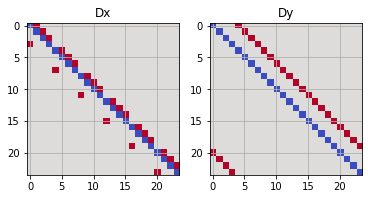

In [ ]:
rows, cols = 6, 4
dx, dy = make_differentiation_matrices(rows, cols, boundary_conditions="periodic")

fig, axes = plt.subplots(1, 2)
axr = axes.ravel()
axr[0].imshow((dx.todense()), cmap="coolwarm")
axr[0].grid(True)
axr[0].set_title("Dx")
axr[1].imshow((dy.todense()), cmap="coolwarm")
axr[1].grid(True)
axr[1].set_title("Dy")

These matrices are used to differentiate the phase and obtain the gradient vector field $\vec{\phi} = [\phi_x, \phi_y]^T$.

The only adjustment fo this problem is to rewrap any derivatives outside the range $[-\pi, \pi]$:

In [ ]:
# export
def est_wrapped_gradient(
    arr, Dx=None, Dy=None, boundary_conditions="neumann", dtype=np.float32
):
    """Estimate the wrapped gradient of `arr` using differential operators `Dx, Dy`
    Adjusts the grad. to be in range [-pi, pi]
    """
    rows, columns = arr.shape
    if Dx is None or Dy is None:
        Dx, Dy = make_differentiation_matrices(
            rows, columns, boundary_conditions=boundary_conditions, dtype=dtype
        )

    phi_x = (Dx @ arr.ravel()).reshape((rows, columns))
    phi_y = (Dy @ arr.ravel()).reshape((rows, columns))
    # Make wrapped adjustmend (eq. (2), (3))
    idxs = np.abs(phi_x) > np.pi
    phi_x[idxs] -= 2 * np.pi * np.sign(phi_x[idxs])
    idxs = np.abs(phi_y) > np.pi
    phi_y[idxs] -= 2 * np.pi * np.sign(phi_y[idxs])
    return phi_x, phi_y

Now the shrinkage operator:

(Source: https://github.com/rickchartrand/regularized_differentiation/blob/master/regularized_differentiation/regularized_gradient.py#L268)

In [ ]:
# export
def p_shrink(X, lmbda=1, p=0, epsilon=0):
    """p-shrinkage in 1-D, with mollification."""

    mag = np.sqrt(np.sum(X ** 2, axis=0))
    nonzero = mag.copy()
    nonzero[mag == 0.0] = 1.0
    mag = (
        np.maximum(
            mag
            - lmbda ** (2.0 - p) * (nonzero ** 2 + epsilon) ** (p / 2.0 - 0.5),  # noqa
            0,
        )
        / nonzero
    )

    return mag * X

The 0th axis is taken to be (x, y), and the magnitude is shrunk together (hence the sum along `axis=0`).

When $p = 0$, this is equal to

$$
S_0(x) = \text{max}(0, |x| - 1/|x|)\text{sign}(x)
$$


(-1.5, 1.5)

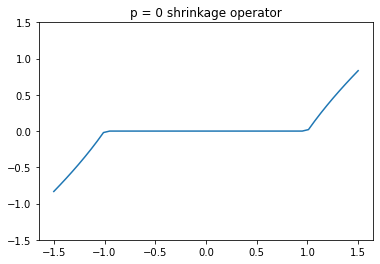

In [ ]:
p = 0
xmin, xmax = -1.5, 1.5
xx = np.linspace(xmin, xmax).reshape((1, -1))
fig, ax = plt.subplots()
ax.plot(xx.ravel(), p_shrink(xx, p=p, epsilon=0).ravel())
ax.set_title(f"p = {p} shrinkage operator")
ax.set_ylim((xmin, xmax))

For the ADMM step of solving the linear system

$$||D \Phi - \phi||_2^2 = 0$$

the $D$ matrices can be diagonalized using the discrete cosine transform (DCT).
Thus, instead of a linear solver, we compute the DCT of the right hand side
$$
D_x^T \phi_x + D_x^T \phi_y
$$
divide by the eigenvalues of the operator, then take the IDCT.

The `make_laplace_kernel` gives the inverse of the eigenvalues, so this can be multiplied by `DCT(rhs)`.

In [ ]:
# export
def make_laplace_kernel(rows, columns, dtype='float32'):
    """Generate eigenvalues of diagonalized Laplacian operator

    Used for quickly solving the linear system ||D \Phi - phi|| = 0

    References:
    Numerical recipes, Section 20.4.1, Eq. 20.4.22 is the Neumann case
    or https://elonen.iki.fi/code/misc-notes/neumann-cosine/
    """
    # Note that sign is reversed from numerical recipes eq., since
    # here since our operator discretization sign reversed
    xi_y = (2 - 2 * np.cos(np.pi * np.arange(rows) / rows)).reshape((-1, 1))
    xi_x = (2 - 2 * np.cos(np.pi * np.arange(columns) / columns)).reshape((1, -1))
    eigvals = xi_y + xi_x

    with np.errstate(divide="ignore"):
        K = np.nan_to_num(1 / eigvals, posinf=0, neginf=0)
    return K.astype(dtype)

In [ ]:
# export
def unwrap(
    f_wrapped,
    phi_x=None,
    phi_y=None,
    max_iters=500,
    tol=np.pi / 5,
    lmbda=1,
    p=0,
    c=1.3,
    dtype="float32",
    debug=False,
    #     boundary_conditions="neumann",
):
    """Unwrap interferogram phase

    Parameters
    ----------
        f_wrapped (ndarray): wrapped phase image (interferogram)
        phi_x (ndarray): estimate of the x-derivative of the wrapped phase
            If not passed, will compute using `est_wrapped_gradient`
        phi_y (ndarray): estimate of the y-derivative of the wrapped phase
            If not passed, will compute using `est_wrapped_gradient`
        max_iters (int): maximum number of ADMM iterations to run
        tol (float): maximum allowed change for any pixel between ADMM iterations
        lmbda (float): splitting parameter of ADMM. Smaller = more stable, Larger = faster convergence.
        p (float): value used in shrinkage operator
        c (float): acceleration constant using in updating lagrange multipliers in ADMM
        dtype: numpy datatype for output
        debug (bool): print diagnostic ADMM information
    """
    rows, columns = f_wrapped.shape
    num = rows * columns

    if dtype is None:
        dtype = f_wrapped.dtype
    else:
        f_wrapped = f_wrapped.astype(dtype)

    boundary_conditions = "neumann"
    if debug:
        print(f"Making Dx, Dy with BCs={boundary_conditions}")
    Dx, Dy = make_differentiation_matrices(
        *f_wrapped.shape, boundary_conditions=boundary_conditions
    )

    if phi_x is None or phi_y is None:
        phi_x, phi_y = est_wrapped_gradient(f_wrapped, Dx, Dy, dtype=dtype)

    # Lagrange multiplier variables
    Lambda_x = np.zeros_like(phi_x, dtype=dtype)
    Lambda_y = np.zeros_like(phi_y, dtype=dtype)

    # aux. variables for ADMM, holding difference between
    # unwrapped phase gradient and measured gradient from igram
    w_x = np.zeros_like(phi_x, dtype=dtype)
    w_y = np.zeros_like(phi_y, dtype=dtype)

    F_old = np.zeros_like(f_wrapped)

    # Get K ready once for solving linear system
    K = make_laplace_kernel(rows, columns, dtype=dtype)

    for iteration in range(max_iters):

        # update Unwrapped Phase F: solve linear eqn in fourier domain
        # rhs = dx.T @ phi[0].ravel() + dy.T @ phi[1].ravel()
        rx = w_x.ravel() + phi_x.ravel() - Lambda_x.ravel()
        ry = w_y.ravel() + phi_y.ravel() - Lambda_y.ravel()
        RHS = Dx.T * rx + Dy.T * ry
        # Use DCT for neumann:
        rho_hat = dctn(RHS.reshape(rows, columns), type=2, norm='ortho', workers=-1)
        F = idctn(rho_hat * K, type=2, norm='ortho', workers=-1)

        # calculate x, y gradients of new unwrapped phase estimate
        Fx = (Dx @ F.ravel()).reshape(rows, columns)
        Fy = (Dy @ F.ravel()).reshape(rows, columns)

        input_x = Fx - phi_x + Lambda_x
        input_y = Fy - phi_y + Lambda_y
        w_x, w_y = p_shrink(
            np.stack((input_x, input_y), axis=0), lmbda=lmbda, p=p, epsilon=0
        )

        # update lagrange multipliers
        Lambda_x += c * (Fx - phi_x - w_x)
        Lambda_y += c * (Fy - phi_y - w_y)

        change = np.max(np.abs(F - F_old))
        if debug:
            print(f"Iteration:{iteration} change={change}")

        if change < tol or np.isnan(change):
            break
        else:
            F_old = F

    if debug:
        print(f"Finished after {iteration} with change={change}")
    return F

## Test case

In [ ]:
# Hide
def plot_diff(a, b, zero_mean=True, cmap="plasma", titles=None, vm=None, figsize=None):
    if zero_mean:
        print("subtracting mean")
        aa = a - a.mean()
        bb = b - b.mean()
    else:
        aa = a
        bb = b

    if titles is None:
        titles = ["a", "b", "diff: a - b"]
    if vm is None:
        vmax = max(np.max(aa), np.max(bb))
        vmin = min(np.min(aa), np.min(bb))
    else:
        vmin, vmax = -vm, vm
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=figsize)
    axim = axes[0].imshow(aa, cmap=cmap, vmin=vmin, vmax=vmax)
    fig.colorbar(axim, ax=axes[0])
    axes[0].set_title(titles[0])

    axim2 = axes[1].imshow(bb, cmap=cmap, vmin=vmin, vmax=vmax)
    fig.colorbar(axim2, ax=axes[1])
    axes[1].set_title(titles[1])

    axim3 = axes[2].imshow(aa - bb, cmap=cmap)
    fig.colorbar(axim3, ax=axes[2])
    if len(titles) >= 3:
        t = titles[2]
    else:
        t = f"Diff: {titles[0]} - {titles[1]}"
    axes[2].set_title(t)

In [ ]:
def make_ramp_test(r=20, c=10, sigma=0.0):

    rramp = 2 * np.arange(-r // 2, r // 2) / 100.0 * 10
    cramp = 2 * np.arange(-c // 2, c // 2) / 100.0 * 10

    # steady ramp from top to bot in both X, Y directions
    X, Y = np.meshgrid(cramp - cramp[0], rramp - rramp[0])

    f0 = np.abs(X) + np.abs(Y)
    f0 = np.max(f0) - f0
    # noise level
    # Unwrapped interferogram phase is f
    f = f0 + sigma * np.random.randn(r, c)
    # Wrapped version of unwrapped truth phase:
    f_wrapped = ((f + np.pi) % (2 * np.pi)) - np.pi
    return f, f_wrapped


f, f_wrapped = make_ramp_test()

subtracting mean


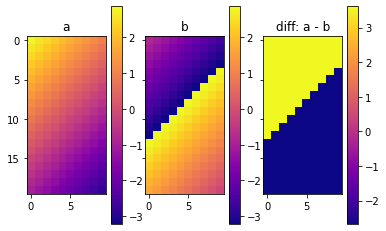

In [ ]:
plot_diff(f, f_wrapped)

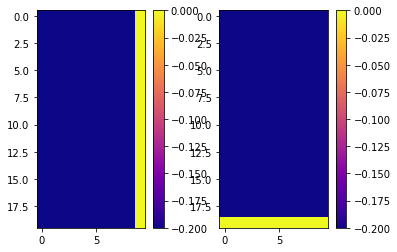

In [ ]:
# estimated phase gradient image: fx, fy
Dx, Dy = make_differentiation_matrices(*f_wrapped.shape, boundary_conditions="neumann")
phi_x, phi_y = est_wrapped_gradient(f_wrapped, Dx=Dx, Dy=Dy)

fig, axes = plt.subplots(1, 2)
axim = axes[0].imshow(phi_x, cmap="plasma")
fig.colorbar(axim, ax=axes[0])
axim = axes[1].imshow(phi_y, cmap="plasma")
fig.colorbar(axim, ax=axes[1])


assert np.allclose(phi_x[:, :-1], -0.2)
assert np.allclose(phi_x[:, -1], 0)
assert np.allclose(phi_y[:-1, :], -0.2)
assert np.allclose(phi_y[-1, :], 0)

In [ ]:
%%time
F = unwrap(f_wrapped, c=1.6, p=0, debug=True)

Making Dx, Dy with BCs=neumann
Iteration:0 change=2.799999952316284
Iteration:1 change=1.2516975402832031e-06
Finished after 1 with change=1.2516975402832031e-06
CPU times: user 5.37 ms, sys: 2.71 ms, total: 8.08 ms
Wall time: 20.4 ms


Note that the unwrapping should produce the same as the truth unwrapped, up to a constant.
Therefore, we subtract the means to compare them:

subtracting mean


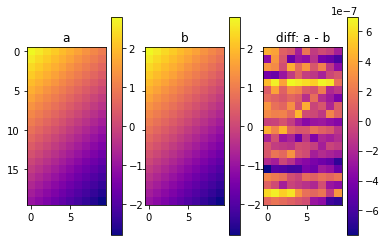

In [ ]:
plot_diff(F, f, zero_mean=True)
assert np.allclose(F - F.mean(), f - f.mean(), atol=1e-6)

# Real interferogram test



In [ ]:
igram = load_interferogram("../test/data/20150328_20150409.int")

igram_phase = np.angle(igram)
print(f"igrams phase dtype, shape: {igram_phase.dtype}, {igram.shape}")

rows, cols = igram.shape

igrams phase dtype, shape: float32, (778, 947)


In [ ]:
%%time
unw_result = unwrap(
    igram_phase, max_iters=100, c=1.3, p=0, lmbda=1, tol=np.pi / 10, debug=True
)

Making Dx, Dy with BCs=neumann
Iteration:0 change=10.16170883178711
Iteration:1 change=3.9912476539611816
Iteration:2 change=3.981320381164551
Iteration:3 change=2.642665147781372
Iteration:4 change=1.6412360668182373
Iteration:5 change=1.230677843093872
Iteration:6 change=0.979617178440094
Iteration:7 change=1.0547046661376953
Iteration:8 change=0.9330539703369141
Iteration:9 change=0.8223729133605957
Iteration:10 change=0.9407191276550293
Iteration:11 change=0.6368851661682129
Iteration:12 change=0.6502038240432739
Iteration:13 change=0.647411584854126
Iteration:14 change=0.5601797103881836
Iteration:15 change=0.6022109985351562
Iteration:16 change=0.5943760871887207
Iteration:17 change=0.5590348243713379
Iteration:18 change=0.6623954772949219
Iteration:19 change=0.64914870262146
Iteration:20 change=0.6600470542907715
Iteration:21 change=0.6056451797485352
Iteration:22 change=0.5549588203430176
Iteration:23 change=0.6354920864105225
Iteration:24 change=0.5680642127990723
Iteration:25

## Comparing result to SNAPHU

subtracting mean


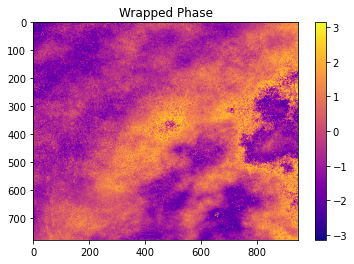

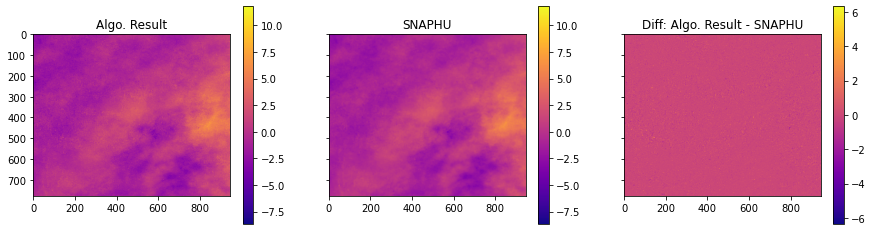

In [ ]:
# For comparison: the results from the SNAPHU unwrapped:
magphase_data = np.fromfile("../test/data/20150328_20150409_snaphu.unw", dtype="float32")
unw_snaphu = magphase_data.reshape((rows, 2 * cols))[:, cols:]


plt.figure()
plt.imshow(igram_phase, cmap="plasma")
plt.colorbar()
plt.title("Wrapped Phase")


plot_diff(
    unw_result,
    unw_snaphu,
    zero_mean=True,
    titles=["Algo. Result", "SNAPHU"],
    figsize=(15, 4),
)

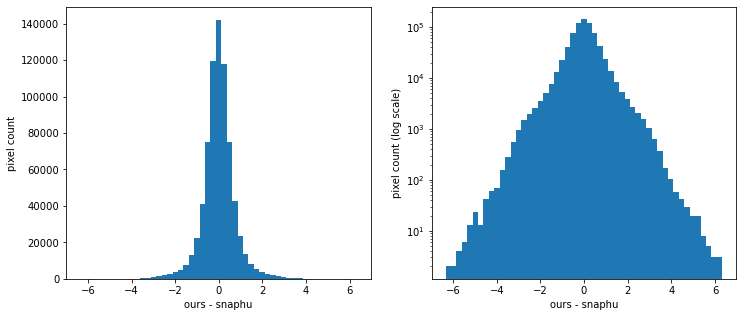

In [ ]:
differences = (unw_result - unw_snaphu).reshape(-1)
differences -= differences.mean()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(differences, bins=51)
axes[0].set_xlabel("ours - snaphu")
axes[0].set_ylabel("pixel count")

axes[1].hist(differences, bins=51)
axes[1].set_xlabel("ours - snaphu")
axes[1].set_ylabel("pixel count (log scale)")
axes[1].set_yscale("log", nonpositive="clip")